In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.8 MB/s eta 0:00:00


# IMPORT LIBRARY

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
import shutil
import random
from sklearn.model_selection import train_test_split

import subprocess
import torch
import ultralytics

import zipfile
from google.colab import files
from ultralytics import YOLO

# KONFIGURASI UNTUK LABELING KEMBALI
Menentukan batas atas dan batas bawah untuk hue, saturasi, dan value untuk membedakan kelas light blue, dark blue, dan others

In [ ]:
DATASET_DIR = '/content/drive/MyDrive/sample'
IMAGE_DIR = DATASET_DIR
LABEL_DIR = DATASET_DIR
NEW_LABEL_DIR = os.path.join(DATASET_DIR, 'new_labels')
os.makedirs(NEW_LABEL_DIR, exist_ok=True)

HUE_LIGHT_BLUE_MIN, HUE_LIGHT_BLUE_MAX = 70, 110
HUE_DARK_BLUE_MIN,  HUE_DARK_BLUE_MAX = 100, 130

SAT_MIN_FOR_COLOR = 40
VAL_MIN_FOR_COLOR = 20
MIN_COLORED_PIXELS = 80

# FUNCTION untuk mendeteksi warna

In [ ]:
def shrink_roi(x1, y1, x2, y2, shrink_ratio=0.2): # Berguna sebagai croping sesuai dengan koordinat YOLO yang diberikan
    w = x2 - x1
    h = y2 - y1
    dx = int(w * shrink_ratio)
    dy = int(h * shrink_ratio)
    return x1 + dx, y1 + dy, x2 - dx, y2 - dy

def detect_color_class(roi_bgr): # Berguna untuk mendeteksi warna sesuai nilai pikselnya
    hsv = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2HSV)
    hue, sat, val = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

    mask_colored = (sat > SAT_MIN_FOR_COLOR) & (val > VAL_MIN_FOR_COLOR)
    if np.sum(mask_colored) < MIN_COLORED_PIXELS:
        return 2

    hue = hue[mask_colored]
    sat = sat[mask_colored]
    val = val[mask_colored]

    hue_med = np.median(hue)
    sat_med = np.median(sat)
    val_med = np.median(val)

    is_blue = (HUE_LIGHT_BLUE_MIN <= hue_med <= HUE_DARK_BLUE_MAX)
    if not is_blue:
        return 2

    if (val_med < 82) or (sat_med > 140):
        return 1

    return 0

In [ ]:
processed = 0
counts = {0: 0, 1: 0, 2: 0}

for filename in os.listdir(LABEL_DIR):
    if filename.endswith(".txt"):
        img_path = os.path.join(IMAGE_DIR, filename.replace(".txt", ".jpg"))
        if not os.path.exists(img_path):
            img_path = os.path.join(IMAGE_DIR, filename.replace(".txt", ".png"))
            if not os.path.exists(img_path):
                print(f"Image missing for {filename}, skipped!")
                continue

        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        new_lines = []

        with open(os.path.join(LABEL_DIR, filename), "r") as f:
            for line in f.read().strip().splitlines():
                parts = line.split()
                cx, cy, bw, bh = map(float, parts[1:5])

                x1 = int((cx - bw / 2) * w)
                y1 = int((cy - bh / 2) * h)
                x2 = int((cx + bw / 2) * w)
                y2 = int((cy + bh / 2) * h)

                x1 = max(0, x1); y1 = max(0, y1)
                x2 = min(w - 1, x2); y2 = min(h - 1, y2)
                sx1, sy1, sx2, sy2 = shrink_roi(x1, y1, x2, y2)
                roi = img[sy1:sy2, sx1:sx2]

                if roi.size == 0:
                    print(f"ROI empty for {filename}, skipped region.")
                    continue

                new_class = detect_color_class(roi)
                counts[new_class] += 1

                new_lines.append(f"{new_class} {cx} {cy} {bw} {bh}")

        with open(os.path.join(NEW_LABEL_DIR, filename), "w") as f:
            f.write("\n".join(new_lines))

        processed += 1

print("=== SELESAI ===")
print(f"Total label files processed: {processed}")
print("Counts per class (0=LightBlue, 1=DarkBlue, 2=Others):")
print(counts)

=== SELESAI ===
Total label files processed: 12
Counts per class (0=LightBlue, 1=DarkBlue, 2=Others):
{0: 22, 1: 16, 2: 41}


# Visualisasi proporsi kelas

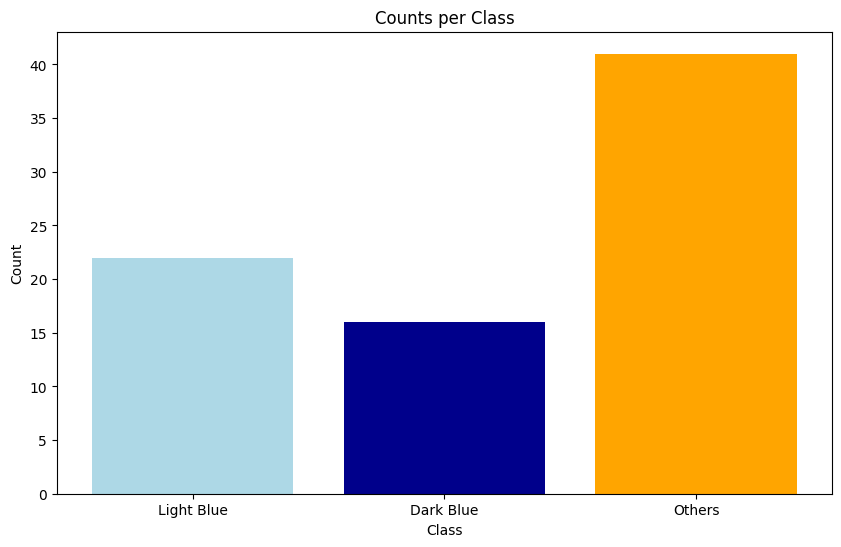

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color=['lightblue', 'darkblue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Counts per Class')
plt.xticks(range(3), ['Light Blue', 'Dark Blue', 'Others'])
plt.show()

# Visualisasi proses labeling kembali

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_color_class(roi_hsv):

    color_ranges = {
        "Light Blue": [(85, 40, 40), (110, 255, 255)],
        "Dark Blue":  [(100, 70, 20), (130, 255, 140)],
    }

    max_pixels = 0
    predicted = "Others"

    for label, (low, high) in color_ranges.items():
        mask = cv2.inRange(roi_hsv, np.array(low), np.array(high))
        count = cv2.countNonZero(mask)
        if count > max_pixels:
            max_pixels = count
            predicted = label

    return predicted



def visualize_color_detection_process(img_path, boxes):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    color_ranges = {
        "Light Blue": [(85, 40, 40), (105, 255, 255)],
        "Dark Blue":  [(100, 70, 20), (130, 255, 140)],
        "Others": None
    }

    for i, (x1, y1, x2, y2) in enumerate(boxes):

        roi = img[y1:y2, x1:x2]
        roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

        label = detect_color_class(roi_hsv)
        if label != "Others":
            low, high = color_ranges[label]
            mask = cv2.inRange(roi_hsv, np.array(low), np.array(high))
        else:
            mask = np.zeros(roi_hsv.shape[:2])

        fig, axs = plt.subplots(1, 3, figsize=(18, 4))

        axs[0].imshow(img_rgb)
        axs[0].set_title("Original Image")

        axs[1].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        axs[1].set_title("ROI")

        axs[2].imshow(cv2.cvtColor(roi_hsv, cv2.COLOR_HSV2RGB))
        axs[2].set_title("HSV")

        for a in axs: a.axis("off")
        plt.show()

        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Final Classification Result")
    plt.axis("off")
    plt.show()



def yolo_to_xyxy(box, img_w, img_h):
    cx, cy, w, h = box
    x1 = int((cx - w / 2) * img_w)
    y1 = int((cy - h / 2) * img_h)
    x2 = int((cx + w / 2) * img_w)
    y2 = int((cy + h / 2) * img_h)
    roi = img[y1:y2, x1:x2]
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    print("RGB/BGR sample pixel:", roi[0,0])  # Contoh satu piksel
    print("HSV sample pixel:", hsv[0,0])

    return x1, y1, x2, y2


RGB/BGR sample pixel: [51 65 47]
HSV sample pixel: [67 71 65]
RGB/BGR sample pixel: [69 82 68]
HSV sample pixel: [62 44 82]
RGB/BGR sample pixel: [68 80 62]
HSV sample pixel: [70 57 80]


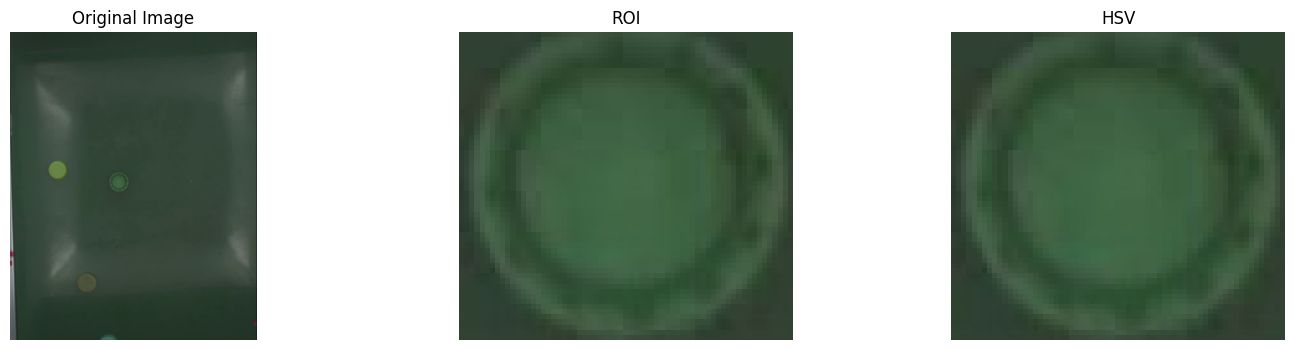

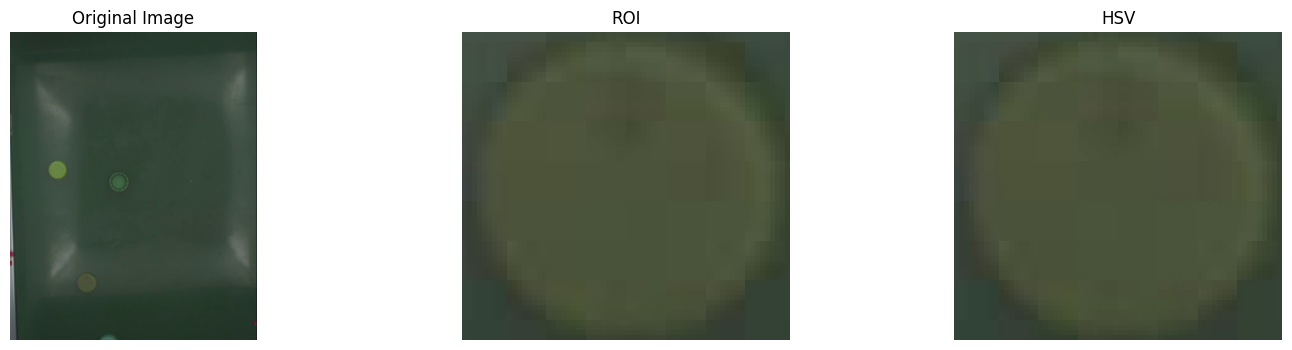

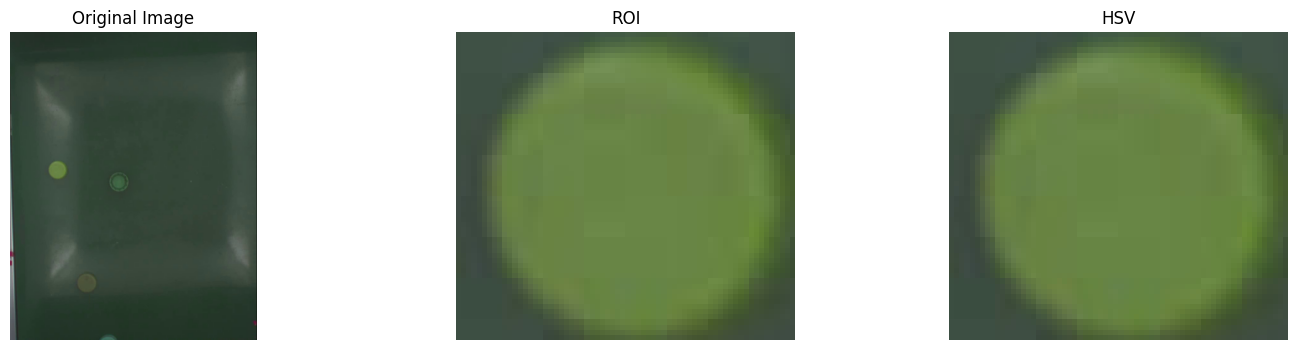

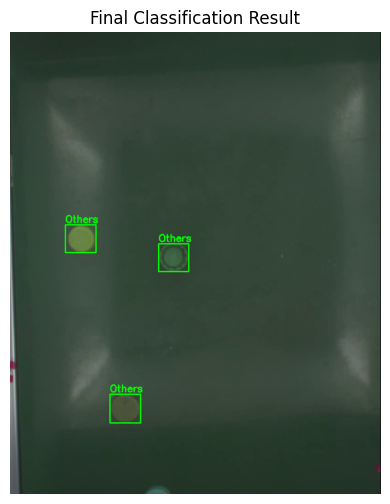

In [ ]:
img_path = "/content/drive/MyDrive/sample/raw-250110_dc_s001_b2_1.jpg"
boxes = [
    (0.441375, 0.488031, 0.081350, 0.060110),
    (0.310675, 0.815020, 0.081350, 0.061503),
    (0.190663, 0.447149, 0.081350, 0.060110),
]

img = cv2.imread(img_path)
img_h, img_w = img.shape[:2]

converted_boxes = [yolo_to_xyxy(b, img_w, img_h) for b in boxes]

visualize_color_detection_process(img_path, converted_boxes)


# Menyimpan preview gambar+bounding box

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/sample"
IMAGE_DIR = DATASET_DIR
LABEL_DIR = os.path.join(DATASET_DIR, "new_labels")
PREVIEW_DIR = os.path.join(DATASET_DIR, "preview")
os.makedirs(PREVIEW_DIR, exist_ok=True)

CLASS_MAP = {
    0: ("Light Blue", (255, 200, 0)),
    1: ("Dark Blue",  (255, 0, 0)),
    2: ("Others",     (0, 255, 255)),
}

valid_image_exts = [".jpg", ".jpeg", ".png", ".bmp"]

for file in os.listdir(LABEL_DIR):
    if not file.endswith(".txt"):
        continue

    base = os.path.splitext(file)[0]

    image_path = None
    for ext in valid_image_exts:
        candidate = os.path.join(IMAGE_DIR, base + ext)
        if os.path.exists(candidate):
            image_path = candidate
            break

    if image_path is None:
        print(f"⚠ Gambar tidak ditemukan untuk label {file}")
        continue

    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    with open(os.path.join(LABEL_DIR, file), "r") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    for line in lines:
        parts = line.split()
        if len(parts) != 5:
            continue

        cls, x, y, bw, bh = parts
        cls = int(cls)
        x, y, bw, bh = map(float, (x, y, bw, bh))

        x1 = int((x - bw/2) * w)
        y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w)
        y2 = int((y + bh/2) * h)

        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        cls_name, color = CLASS_MAP.get(cls, ("Unknown", (0, 0, 0)))

        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        cv2.rectangle(img, (x1, y1 - 18), (x1 + 150, y1), color, -1)
        cv2.putText(img, cls_name, (x1 + 4, y1 - 4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (0, 0, 0), 1, cv2.LINE_AA)

    # simpan hasil
    out_path = os.path.join(PREVIEW_DIR, base + ".jpg")
    cv2.imwrite(out_path, img)
    print(f"✔ Preview disimpan → {out_path}")

print("\n=== SELESAI! Semua result tersimpan di folder /preview ===")

✔ Preview disimpan → /content/drive/MyDrive/sample/preview/raw-250110_dc_s001_b5_3.jpg
✔ Preview disimpan → /content/drive/MyDrive/sample/preview/raw-250110_dc_s001_b4_2.jpg
✔ Preview disimpan → /content/drive/MyDrive/sample/preview/raw-250110_dc_s001_b5_5.jpg
✔ Preview disimpan → /content/drive/MyDrive/sample/preview/raw-250110_dc_s001_b2_1.jpg
✔ Preview disimpan → /content/drive/MyDrive/sample/preview/raw-250110_dc_s001_b2_15.jpg
✔ Preview disimpan → /content/drive/MyDrive/sample/preview/raw-250110_dc_s001_b5_2.jpg
✔ Preview disimpan → /content/drive/MyDrive/sample/preview/raw-250110_dc_s001_b4_3.jpg
✔ Preview disimpan → /content/drive/MyDrive/sample/preview/raw-250110_dc_s001_b2_3.jpg
✔ Preview disimpan → /content/drive/MyDrive/sample/preview/raw-250110_dc_s001_b4_1.jpg
✔ Preview disimpan → /content/drive/MyDrive/sample/preview/raw-250110_dc_s001_b3_2.jpg
✔ Preview disimpan → /content/drive/MyDrive/sample/preview/raw-250110_dc_s001_b3_3.jpg
✔ Preview disimpan → /content/drive/MyDriv

# Membagi Dataset

Dataset dibagi menjadi:

Data Train (80%) : 9 file

Data Val (10%) : 1 file

Data Test (10%) : 2 file

In [ ]:
DRIVE_BASE_PATH = "/content/drive/MyDrive"

SOURCE_IMAGE_DIR = os.path.join(DRIVE_BASE_PATH, "sample")
SOURCE_LABEL_DIR = os.path.join(DRIVE_BASE_PATH, "sample", "new_labels")
BASE_OUTPUT_DIR = os.path.join(DRIVE_BASE_PATH, "yolo_custom_dataset")

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
RANDOM_SEED = 42

In [ ]:
def split_yolo_dataset_to_drive():
    if TRAIN_RATIO + VAL_RATIO + TEST_RATIO != 1.0:
        raise ValueError("Total rasio (Train + Val + Test) harus sama dengan 1.0")

    if not os.path.exists(SOURCE_IMAGE_DIR) or not os.path.exists(SOURCE_LABEL_DIR):
        print(f"❌ Error: Salah satu direktori sumber tidak ditemukan:")
        print(f"  Gambar: {SOURCE_IMAGE_DIR}")
        print(f"  Label: {SOURCE_LABEL_DIR}")
        print("Pastikan Google Drive Anda sudah terhubung dan path-nya benar.")
        return

    image_files = [f for f in os.listdir(SOURCE_IMAGE_DIR) if f.endswith('.jpg')]
    if not image_files:
        print(f"❌ Error: Tidak ada file .jpg yang ditemukan di {SOURCE_IMAGE_DIR}")
        return

    print(f"✅ Ditemukan total {len(image_files)} gambar untuk diproses.")

    train_files, temp_files = train_test_split(
        image_files,
        test_size=VAL_RATIO + TEST_RATIO,
        random_state=RANDOM_SEED
    )
    val_files, test_files = train_test_split(
        temp_files,
        test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
        random_state=RANDOM_SEED
    )

    datasets = {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }

    print(f"🗑️ Membersihkan folder output lama di {BASE_OUTPUT_DIR}...")
    if os.path.exists(BASE_OUTPUT_DIR):
        shutil.rmtree(BASE_OUTPUT_DIR)

    for split in datasets.keys():
        os.makedirs(os.path.join(BASE_OUTPUT_DIR, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(BASE_OUTPUT_DIR, 'labels', split), exist_ok=True)

    print(f"📁 Struktur folder tujuan baru dibuat di Google Drive.")
    print("\n📦 Memulai penyalinan file ke Google Drive (mungkin perlu waktu)...")

    for split_name, file_list in datasets.items():
        image_count = 0
        label_count = 0
        print(f"--- Memproses {split_name.upper()} ({len(file_list)} file) ---")

        for img_name in file_list:
            src_img_path = os.path.join(SOURCE_IMAGE_DIR, img_name)
            dst_img_path = os.path.join(BASE_OUTPUT_DIR, 'images', split_name, img_name)
            shutil.copy(src_img_path, dst_img_path)
            image_count += 1

            label_name = img_name.replace('.jpg', '.txt')
            src_label_path = os.path.join(SOURCE_LABEL_DIR, label_name)
            dst_label_path = os.path.join(BASE_OUTPUT_DIR, 'labels', split_name, label_name)

            if os.path.exists(src_label_path):
                shutil.copy(src_label_path, dst_label_path)
                label_count += 1
            else:
                print(f"⚠️ Peringatan: Label tidak ditemukan untuk gambar {img_name}. File dilewati.")
                os.remove(dst_img_path)
                image_count -= 1

        print(f"Selesai: {image_count} Gambar dan {label_count} Label disalin ke {split_name}.")

    print("\n🎉 Proses Pembagian Dataset Selesai dan Tersimpan di Google Drive!")
    print(f"Dataset siap untuk pelatihan di: {BASE_OUTPUT_DIR}")

In [ ]:
split_yolo_dataset_to_drive()

✅ Ditemukan total 12 gambar untuk diproses.
🗑️ Membersihkan folder output lama di /content/drive/MyDrive/yolo_custom_dataset...
📁 Struktur folder tujuan baru dibuat di Google Drive.

📦 Memulai penyalinan file ke Google Drive (mungkin perlu waktu)...
--- Memproses TRAIN (9 file) ---
Selesai: 9 Gambar dan 9 Label disalin ke train.
--- Memproses VAL (1 file) ---
Selesai: 1 Gambar dan 1 Label disalin ke val.
--- Memproses TEST (2 file) ---
Selesai: 2 Gambar dan 2 Label disalin ke test.

🎉 Proses Pembagian Dataset Selesai dan Tersimpan di Google Drive!
Dataset siap untuk pelatihan di: /content/drive/MyDrive/yolo_custom_dataset


# Membangun model yolov8n



In [ ]:
DATA_YAML_PATH = '/content/bottle.yaml'
MODEL_NAME = 'yolov8n.pt'
NUM_EPOCHS = 100
IMG_SIZE = 640
BATCH_SIZE = 16

PROJECT_NAME = 'New_yolov8n_bottle_project'
RUN_NAME = 'caps_nano_run'

def train_yolov8_model():
    """
    Menjalankan pelatihan YOLOv8n menggunakan subprocess untuk memanggil CLI.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Menggunakan perangkat: {device.upper()}")

    if not os.path.exists(DATA_YAML_PATH):
        print(f"❌ ERROR: File data YAML tidak ditemukan di: {DATA_YAML_PATH}")
        print("Pastikan Anda sudah memindahkan atau membuat file bottle.yaml di lokasi /content/.")
        return

    command = [
        'yolo',
        'train',
        f'data={DATA_YAML_PATH}',
        f'model={MODEL_NAME}',
        f'epochs={NUM_EPOCHS}',
        f'imgsz={IMG_SIZE}',
        f'batch={BATCH_SIZE}',
        f'project={PROJECT_NAME}',
        f'name={RUN_NAME}',
        f'device={0 if device == "cuda" else "cpu"}'
    ]

    print("\n🚀 Memulai Pelatihan YOLOv8n...")
    print(f"Perintah yang dijalankan: {' '.join(command)}")

    try:
        process = subprocess.run(
            command,
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        print("\n--- Output Pelatihan ---")
        print(process.stdout)
        print("--------------------------")
        print(f"\n✅ Pelatihan selesai! Hasil tersimpan di: {PROJECT_NAME}/{RUN_NAME}")

    except FileNotFoundError:
        print("\n❌ ERROR: Perintah 'yolo' tidak ditemukan.")
        print("Harap instal pustaka Ultralytics/YOLO: `!pip install ultralytics`")
    except subprocess.CalledProcessError as e:
        print(f"\n❌ ERROR Pelatihan Gagal:")
        print(e.stderr)
    except Exception as e:
        print(f"\n❌ ERROR Tak Terduga: {e}")

train_yolov8_model()

Menggunakan perangkat: CPU

🚀 Memulai Pelatihan YOLOv8n...
Perintah yang dijalankan: yolo train data=/content/bottle.yaml model=yolov8n.pt epochs=100 imgsz=640 batch=16 project=New_yolov8n_bottle_project name=caps_nano_run device=cpu

--- Output Pelatihan ---
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/bottle.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mas

# Testing performa model yolov8n

In [ ]:
MODEL_WEIGHTS_PATH = '/content/New_yolov8n_bottle_project/caps_nano_run/weights/last.pt'
SOURCE_IMAGE_DIR = '/content/drive/MyDrive/yolo_custom_dataset/images/test'


CONFIDENCE_THRESHOLD = 0.2
PROJECT_NAME = 'New_inference_resultsv81'
RUN_NAME = 'last_set_eval'

def run_yolo_inference():
    if not os.path.exists(MODEL_WEIGHTS_PATH):
        print(f"❌ ERROR: File weights model tidak ditemukan di: {MODEL_WEIGHTS_PATH}")
        print("Harap ganti 'MODEL_WEIGHTS_PATH' dengan path yang benar.")
        return

    if not os.path.exists(SOURCE_IMAGE_DIR):
        print(f"❌ ERROR: Folder gambar sumber tidak ditemukan di: {SOURCE_IMAGE_DIR}")
        print("Harap ganti 'SOURCE_IMAGE_DIR' dengan path yang benar ke gambar Test Set Anda.")
        return

    command = [
        'yolo',
        'detect',
        'predict',
        f'model={MODEL_WEIGHTS_PATH}',
        f'source={SOURCE_IMAGE_DIR}',
        f'conf={CONFIDENCE_THRESHOLD}',
        f'project={PROJECT_NAME}',
        f'name={RUN_NAME}',
        'save=True'
    ]

    print("\n🚀 Memulai Inferensi pada Test Set...")
    print(f"Perintah yang dijalankan: {' '.join(command)}")

    try:
        process = subprocess.run(
            command,
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        print("\n--- Output Inferensi ---")
        print(process.stdout)

        output_path = os.path.join(PROJECT_NAME, RUN_NAME)
        print(f"--------------------------")
        print(f"\n✅ Inferensi selesai! Hasil visual (gambar ber-BB) tersimpan di folder: {output_path}")

    except FileNotFoundError:
        print("\n❌ ERROR: Perintah 'yolo' tidak ditemukan.")
        print("Harap instal pustaka Ultralytics/YOLO: `!pip install ultralytics`")
    except subprocess.CalledProcessError as e:
        print(f"\n❌ ERROR Inferensi Gagal:")
        print(e.stderr)
    except Exception as e:
        print(f"\n❌ ERROR Tak Terduga: {e}")

run_yolo_inference()


🚀 Memulai Inferensi pada Test Set...
Perintah yang dijalankan: yolo detect predict model=/content/new_yolov8_bottle_cap_project/caps_nano_run/weights/best.pt source=/content/drive/MyDrive/yolo_custom_dataset/images/test conf=0.2 project=New_inference_resultsv82 name=best_set_eval save=True

--- Output Inferensi ---
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

image 1/2 /content/drive/MyDrive/yolo_custom_dataset/images/test/raw-250110_dc_s001_b2_15.jpg: 640x544 1 Light Blue, 6 Otherss, 226.6ms
image 2/2 /content/drive/MyDrive/yolo_custom_dataset/images/test/raw-250110_dc_s001_b3_4.jpg: 640x544 10 Otherss, 197.3ms
Speed: 6.9ms preprocess, 211.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 544)
Results saved to /content/New_inference_resultsv82/best_set_eval
💡 Learn more at https://docs.ultralytics.com/modes/predict

--------------------------

✅ Infe